In [1]:
import os
import random
import matplotlib.pyplot as plt
import tqdm

from bbchallenge import *

In [2]:
DB_PATH = "all_5_states_undecided_machines_with_global_header"

In [3]:
header = get_header(DB_PATH)
undecided_time, undecided_space, undecided_total, is_lex_sorted = int.from_bytes(header[:4],byteorder='big'),int.from_bytes(header[4:8],byteorder='big'),\
                                                                  int.from_bytes(header[8:12],byteorder='big'), header[12]
print(undecided_time, undecided_space, undecided_total, is_lex_sorted)

14322029 74342035 88664064 1


# Context

We want a heuristic to recognise exponential counters:

## Exponential counters

12012425
s    0    1
---  ---  ---
A    1RB  1LC
B    0LA  0RB
C    1RD  1LD
D    0RE  1LC
E    ???  1LA


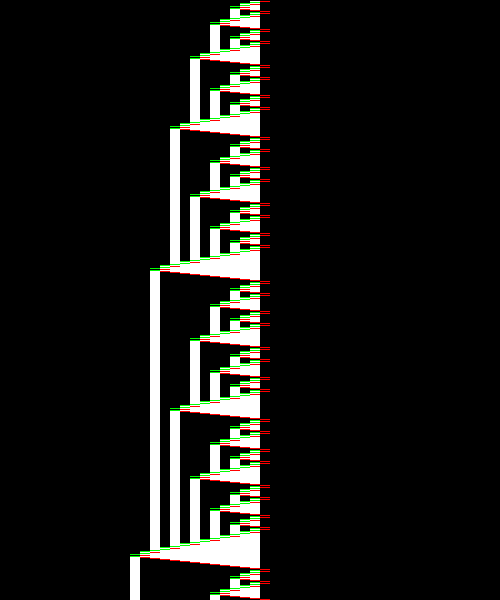

In [5]:
n = random.choice(zoo.exponential_counters)
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=50, height=600, show_head_direction=True).resize((500,600), Image.NEAREST)
img

# Exponential Record Times Heuristic

We reason that the sequence of time steps at which the head breaks a new record in a direction (i.e. discovers a cell that had never been visitided before) must be exponential.

Based on experimentations we conjecture that the sequences of records follow the recurrence equation:

$$ r_{n+1} = Ar_{n} + P(n) $$

With $A >= 2$ a natural number and $P$ a polynomial.

In practice $A \in \{2,3,4\}$ and $P$ is of degree $1$.

In practice we have to consider subsequences of the record sequence and the following works: `record_times[::k]` for `k=1,2,3,4,5`.

In [6]:
R,L = 0,1
def simulate_and_get_record_times(machine, time_limit = 10000000, record_limit = None):
    curr_time = 0
    curr_state = 0
    curr_pos = 0
    tape = {}
    
    record_times = [{},{}] # right and left records
    record_times[R] = {0: 0} #time: pos
    record_times[L] = {0: 0} #time: pos
    
    while curr_state != None and curr_time < time_limit:
        if curr_pos < min(record_times[L].values()):
            record_times[L][curr_time] = curr_pos
            
        if curr_pos > max(record_times[R].values()):
            record_times[R][curr_time] = curr_pos
            
        if record_limit is not None:
            if len(record_times[L]) > record_limit or len(record_times[R]) > record_limit:
                return record_times
        
        curr_state, curr_pos = step(machine, curr_state, curr_pos, tape)
        # Halt!
        if curr_state is None:
            return record_times
        curr_time += 1
    
    return record_times

In [8]:
def diff_n(l,n=1):
    lc = l[:]
    def diff(l):
        if len(l) < 2:
            return []
        to_ret = []
        for i in range(1,len(l)):
            to_ret.append(l[i]-l[i-1])
        return to_ret
    for i in range(n):
        lc = diff(lc)
    return lc

In [9]:
def all_zero(l):
    for a in l:
        if a != 0:
            return False
    return True

10126234
s    0    1
---  ---  ---
A    1RB  1RE
B    0RC  ???
C    1LD  1RC
D    0LA  1LE
E    0RC  0LD


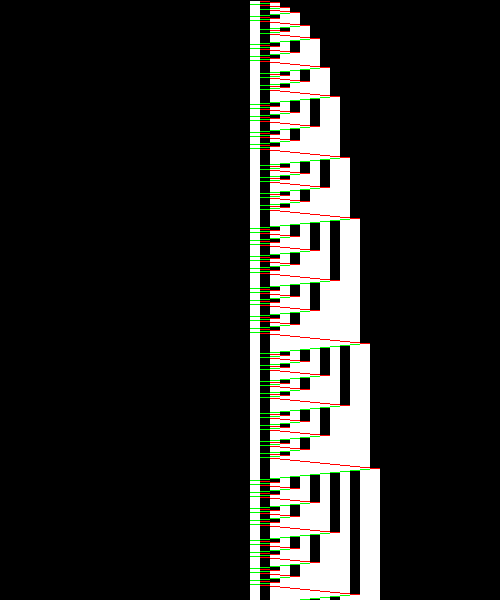

In [10]:
n = 10126234
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=50, height=600, show_head_direction=True).resize((500,600), Image.NEAREST)
img

In [11]:
record_times = simulate_and_get_record_times(get_machine_i(DB_PATH,n))

In [12]:
len(record_times[R])

41

### We then play with parameters k and A until we find a Polynomial

Our hypothesis is that $r_{n+1} = Ar_n + P(n)$. Hence we compute $r_{n+1} - Ar_n$ for different values of $A$ until we find a polynomial (in practice we always find a line).

Parameter $k$ is the sub-sampling of our record sequence

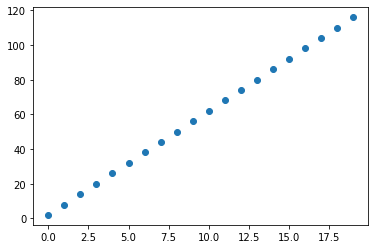

In [13]:
a = list(record_times[R].keys())[::2]
b = []
for i in range(1,len(a)):
    b.append(a[i] - 2*a[i-1])
plt.plot(b, 'o')
plt.show()

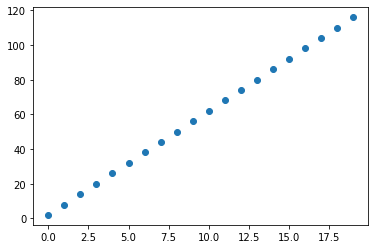

In [14]:
a = list(record_times[R].keys())[::2]
b = []
for i in range(1,len(a)):
    b.append(a[i] - 2*a[i-1])
plt.plot(b, 'o')
plt.show()

### ^ This is a Polynomial of degree 1

In [15]:
print(diff_n(b,2))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [16]:
def plot_parameter_space(record_times, n, maxA=5, maxk=5, diff=None):
    plt.figure(figsize=(11,12))
    i_plot = 1
    for k in range(maxk):
        for A in range(2,maxA+1):
            plt.subplot(maxk,maxA-1,i_plot)
            a = list(record_times.keys())[::k+1]
            b = []
            for i in range(1,len(a)):
                b.append(a[i] - A*a[i-1])
            if diff is None:
                plt.plot(b, 'o')
            else:
                plt.plot(diff_n(b,diff),'o')
            plt.title(f"k={k+1} A={A}")
            i_plot += 1
    plt.suptitle(f"Parameter space for machine n={n} ({len(record_times)} records)")
    plt.tight_layout(pad=1.0)
    plt.show()

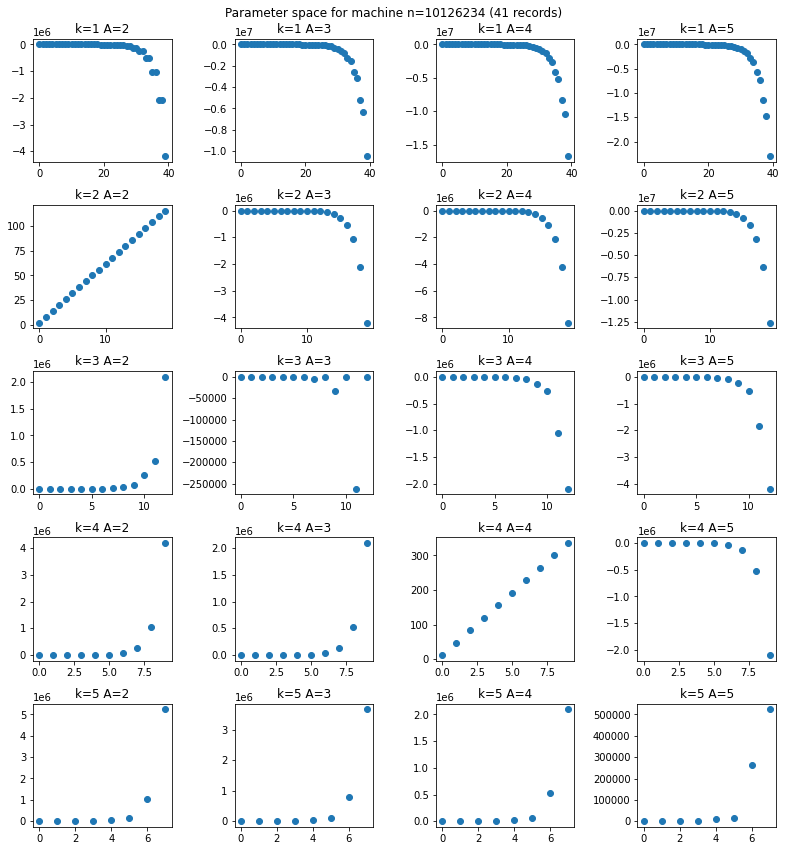

In [17]:
plot_parameter_space(record_times[R],n)

## Parameters for all our examples of exponential counters

In [25]:
heuristic_parameters = \
{14244805: (L,2,2), 8413822: (R,3,3),  7695094: (L,2,2), 
 2351048: (L,1,2), 2940201: (R,1,2),  437775: (R,1,2), 
 10126234: (R,2,2),  12012425: (L,2,2),   6776164: (L,1,2), 
 3266856: (L,4,2), 6486385: (L,2,2), 6245415: (R,2,4),
 9987686: None}

In [19]:
all_record_times = {}
for n_machine in tqdm.tqdm(heuristic_parameters):
    all_record_times[n_machine] = simulate_and_get_record_times(get_machine_i(DB_PATH,n_machine))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [02:14<00:00, 10.38s/it]


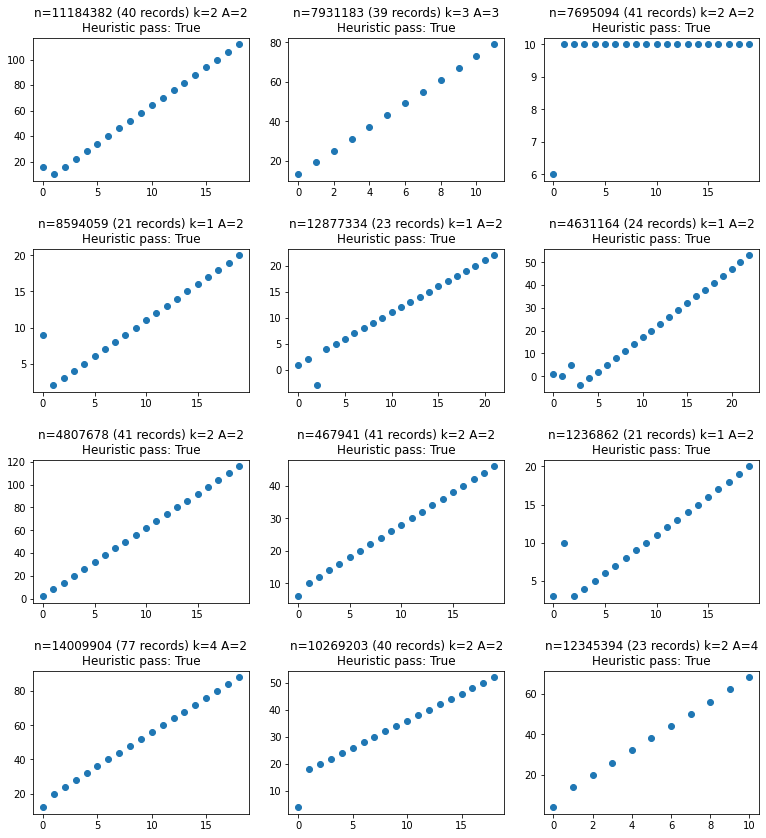

In [227]:
plt.figure(figsize=(11,12))
i_plot = 1
for n_machine in heuristic_parameters:
    if heuristic_parameters[n_machine] is None:
        continue
    side,k,A = heuristic_parameters[n_machine]
    plt.subplot(4,3,i_plot)
    a = list(all_record_times[n_machine][side].keys())[::k]
    b = []
    for i in range(1,len(a)):
        b.append(a[i] - A*a[i-1])
    plt.plot(b, 'o')
    
    second_derivative = diff_n(b,2)
    nb_points_to_conclude = 8
    heuristic_pass = len(second_derivative) >= nb_points_to_conclude and all_zero(second_derivative[-nb_points_to_conclude:])
    
    plt.title(f"n={n_machine} ({len(all_record_times[n_machine][side].keys())} records) k={k} A={A}\nHeuristic pass: {heuristic_pass}")
    i_plot += 1
plt.tight_layout(pad=2.0)
plt.show()

# Heuristic Code

Note that because of the exponential nature of the machines that we are looking for the number of records is quite small VS the number of time steps the machine was run. Here we run machines for 10M steps and get max 77 records in our examples. Hence we can fix in the heuristic a max number of records before ditching the machine being considered (e.g. 200). This is helpful when testing the heuristic on counter example as we don't want to explode the memory of our computer with a linear number of records in 10M steps.

In [22]:
def heuristic_exponential_record_times(machine, time_limit=10000000, record_limit = 200,
                         nb_points_to_conclude = 8, 
                         max_A = 5, max_k = 5, 
                         debug=False):
    
    record_times = simulate_and_get_record_times(machine, time_limit=time_limit, record_limit = record_limit)
    
    side = R
    # take the side with the most records
    if len(record_times[R]) < len(record_times[L]):
        side = L
    
    # too many records means exponential behavior unlikely
    if len(record_times[side]) > record_limit:
        return False

    for k in range(1,max_k+1):
        for A in range(2,max_A+1):
            a = list(record_times[side].keys())[::k]
            b = []
            for i in range(1,len(a)):
                b.append(a[i] - A*a[i-1])
            
            second_derivative = diff_n(b,2)
            heuristic_pass = len(second_derivative) >= nb_points_to_conclude and all_zero(second_derivative[-nb_points_to_conclude:])
            
            if heuristic_pass:
                return True
            
    return False

# Testing the Heuristic

## Heuristic should say True

In [23]:
print(f"Testing {len(heuristic_parameters)-1} machines")

Testing 12 machines


In [27]:
for n_machine in tqdm.tqdm(heuristic_parameters):
    if heuristic_parameters[n_machine] is None:
        continue
    if not heuristic_exponential_record_times(get_machine_i(DB_PATH,n_machine)):
        print("Problem:", n)

 23%|███████████████████████████                                                                                          | 3/13 [00:32<01:45, 10.55s/it]

Problem: 14263231


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [02:13<00:00, 10.25s/it]


## Heuristic should say False

In [28]:
print(f"Testing {len(zoo.unilateral_pongs + zoo.bilateral_pongs + zoo.translated_unilateral_pongs + zoo.potential_halters + zoo.halters)} machines")
for n in tqdm.tqdm(zoo.unilateral_pongs + zoo.bilateral_pongs + zoo.translated_unilateral_pongs + zoo.potential_halters):
    if heuristic_exponential_record_times(get_machine_i(DB_PATH,n)):
        print("Problem:", n)

Testing 155 machines


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:38<00:00,  3.86it/s]


In [29]:
for machine in tqdm.tqdm(zoo.halters):
    if heuristic_exponential_record_times(machine):
        print("Problem:", n)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 43.10it/s]


## The method does not crack n = 14263231 which is very special (smart counter in both directions)

14263231
s    0    1
---  ---  ---
A    1RB  1LE
B    1LC  1RD
C    1LA  0RC
D    1RE  ???
E    1RC  0LE


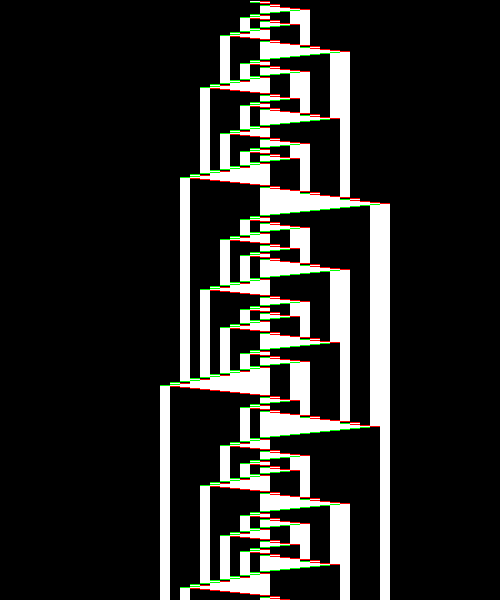

In [30]:
n = 14263231
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=50, height=600, show_head_direction=True).resize((500,600), Image.NEAREST)
img

In [31]:
record_times = simulate_and_get_record_times(get_machine_i(DB_PATH,n))

In [32]:
len(record_times[L]), len(record_times[R])

(38, 50)

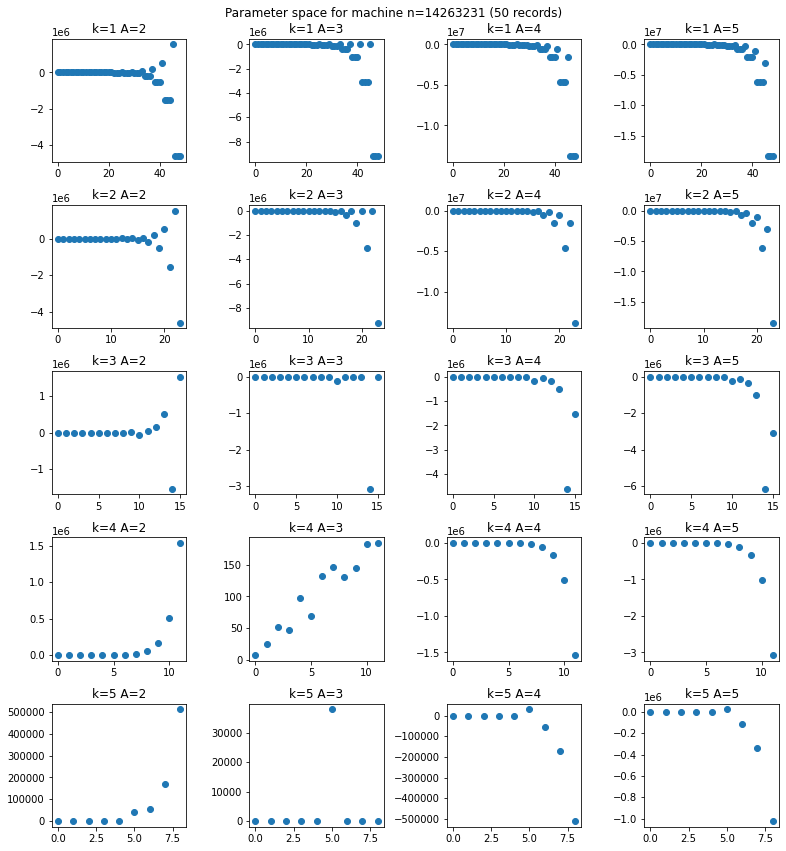

In [34]:
plot_parameter_space(record_times[R], 14263231)

## The method does not crack n = 10128798 which seems to grow at a non-integer rate

10128798
s    0    1
---  ---  ---
A    1RB  1RE
B    0RC  ???
C    1LD  1LA
D    1RA  1LD
E    0LC  0RE


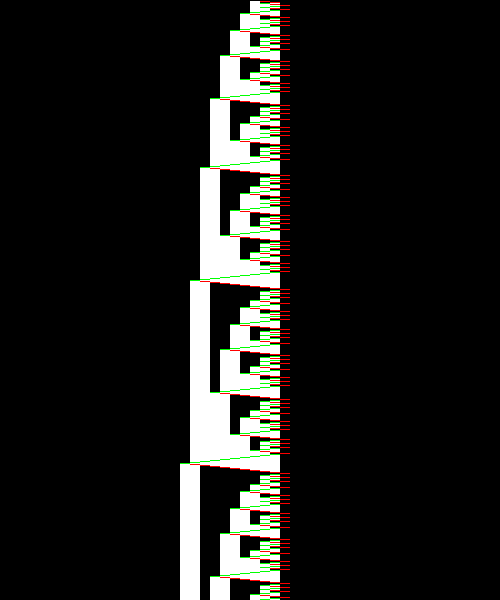

In [36]:
n = 10128798
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=50, height=600, show_head_direction=True).resize((500,600), Image.NEAREST)
img

In [37]:
record_times = simulate_and_get_record_times(get_machine_i(DB_PATH,n))

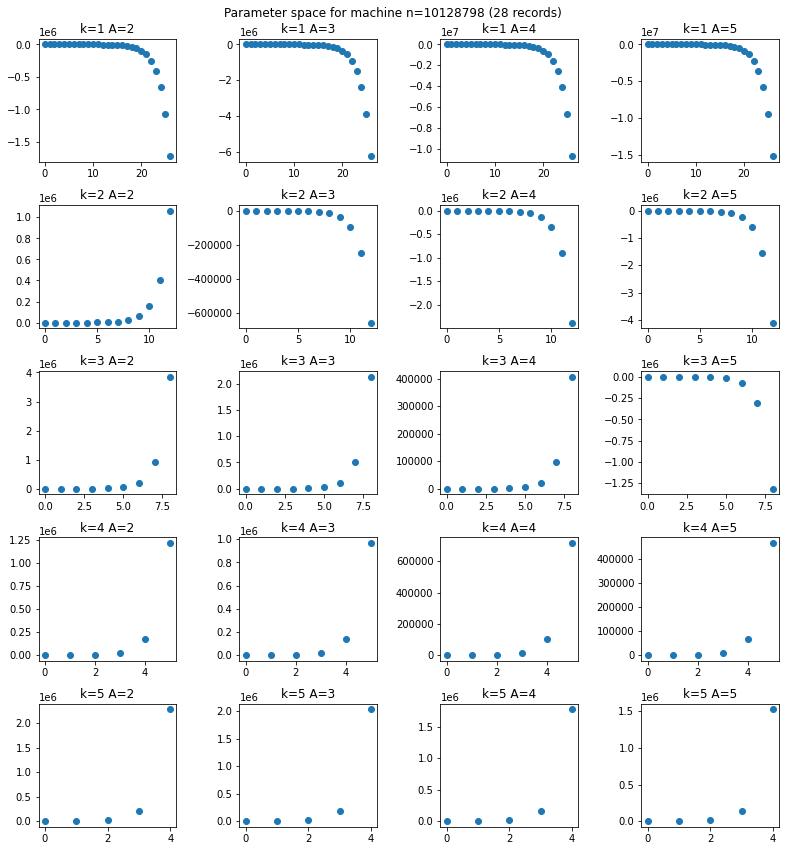

In [38]:
plot_parameter_space(record_times[L],n)

## Other unrecognised exponential counters

The following exponential counters do not pass the heuristic.

In [39]:
other_unrecognised_exponential_counters = [12986396, 10035798, 12297831, 11042497, 5817663, 12730831, 7395245, 
                                           8197096, 3305285, 8605016, 852425, 10987920, 2169147, 5133713, 12110495, 13984719]

# Counting records heuristic

A way simpler heuristics consists in checking if the number of records beaten by a machine after 10M steps is too low. All the exponential counters that we have achieve < 80 records in 10M steps.

In [48]:
rec_length = []

In [49]:
for n in all_record_times:
    rec_length.append(max(len(all_record_times[n][0]),len(all_record_times[n][1])))

In [50]:
for n in tqdm.tqdm(other_unrecognised_exponential_counters):
    record_times = simulate_and_get_record_times(get_machine_i(DB_PATH,n))
    rec_length.append(max(len(record_times[0]),len(record_times[1])))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [02:40<00:00, 10.05s/it]


In [51]:
print(rec_length)

[40, 39, 3, 41, 23, 24, 41, 41, 21, 77, 40, 23, 50, 32, 63, 30, 31, 21, 24, 22, 32, 32, 31, 21, 24, 54, 29, 37, 39]


^ all the above record lengths are < 80

# Results

- On Feb 23rd 2022, `151,063` machines passed the exponential record time heuristic (out of `2,322,122` remaining undecided machines).

- On March 5th 2022, `20,954` machines, that did not pass the exponential time heuristic, passed the "counting records" heuristic (out of `2,322,122` remaining undecided machines).